In [3]:
#mon_env_gdn
import pandas as pd
import os
import re
import nltk
import numpy as np
import time
import matplotlib as plt 
import seaborn as sns
import sklearn
from tqdm.notebook import tqdm as tqdm
from pprint import pprint
import gensim
import spacy
import tweepy as tw
import textblob_fr
import textblob
#os.chdir(r"C:\Users\csamassa\Desktop\Mémoire\Nouveau GDN")
os.chdir(r"C:\Users\Cheik\Desktop\mémoire")
#nltk.download('punkt')

C:\Users\Cheik\anaconda3\lib\site-packages\nltk\decorators.py:68: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  regargs, varargs, varkwargs, defaults, formatvalue=lambda value: ""
C:\Users\Cheik\anaconda3\lib\site-packages\nltk\lm\counter.py:15: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Sequence, defaultdict
C:\Users\Cheik\anaconda3\lib\site-packages\nltk\lm\vocabulary.py:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Counter, Iterable
C:\Users\Cheik\anaconda3\lib\site-packages\botocore\vendored\requests\packages\urllib3\_collections.py:1: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 

In [4]:
start_time = time.time()

demo=pd.read_csv("DEMOCRATIE_ET_CITOYENNETE.csv", 
                 sep=",",
                 #nrows=10,
                 usecols=[0,10,2,11,13,14,16,17,19,20,22,23,25,26,27,29,30,31,32,33,34,35,36,37,38,39,40,42,43,44,45,46,47]
                 ,dtype={"authorZipCode":object}
                 )
fisc=pd.read_csv("LA_FISCALITE_ET_LES_DEPENSES_PUBLIQUES.csv", 
                 sep=",",
                 #nrows=10,
                 usecols=[0,10,2,11,12,13,14,15,16,17,18]
                 ,dtype={"authorZipCode":object}
                 )
eco=pd.read_csv("LA_TRANSITION_ECOLOGIQUE.csv", 
                sep=",",
                #nrows=10,               
                usecols=[0,10,2,11,12,14,16,17,18,20,22,23,24,25,26]
                ,dtype={"authorZipCode":object}
                )
                
org=pd.read_csv("ORGANISATION_DE_LETAT_ET_DES_SERVICES_PUBLICS.csv", 
                sep=",",
               #nrows=10,
                usecols=[0,10,2,11,13,15,16,19,20,21,24,25,27,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43]
                ,dtype={"authorZipCode":object}
               )
print("--- %s seconds ---" % (time.time() - start_time))

--- 34.682637214660645 seconds ---


In [5]:
start_time = time.time()
# On rajoute une colonne comportant le thème de chaque question
demo.insert(column="Thème",value="DEMOCRATIE ET CITOYENNETE",loc=3)
fisc.insert(column="Thème",value="LA FISCALITE ET LES DEPENSES PUBLIQUES",loc=3)
eco.insert(column="Thème",value="LA TRANSITION ECOLOGIQUE",loc=3)
org.insert(column="Thème",value="ORGANISATION DE L'ETAT ET DES SERVICES PUBLIQUES",loc=3)


# On nettoie le début des questions
def clean_question(df):
    colonnes=df.columns
    colonnes1=[re.sub(pattern=r"\bQ[A-Za-z0-9]+\s+\-\s",repl='',string=nom) for nom in colonnes]
    return(colonnes1)



# On applique tt en même temps
demo.columns,fisc.columns,eco.columns,org.columns=clean_question(demo),clean_question(fisc),clean_question(eco),clean_question(org)
col1=["id", "authorZipCode","Thème"]

def empiller(df):
    stack_0=df.loc[:, ~df.columns.isin(col1)].stack(dropna=False) # prend les QO (toutes les questions sauf celles de col1)
    stack_1=stack_0.reset_index()                                 # On supp l'index pour avoir le level 0 pour la future jointure
    stack_2=stack_1.merge(df[col1],left_on="level_0",right_index=True,how="left")
    stack_2.columns=["idx_0","Question","Réponse","id","authorZipCode","Thème"] #idx_0 c'est le numéro de la ligne dans le fichier original de chaque thème 
    stack_2.dropna(inplace=True)
    return stack_2


demo_1,fisc_1,eco_1,org_1=empiller(demo),empiller(fisc),empiller(eco),empiller(org)

del(demo,fisc,eco,org)# On supp les variables inutiles de l'environnement

contributions=pd.concat([demo_1,fisc_1,eco_1,org_1],axis=0)   #On met tout dans un même df
 
contributions.reset_index(drop=True,inplace=True)

del(demo_1,fisc_1,eco_1,org_1,col1)

contributions.drop(columns="id", inplace=True) # On supp la colonne (on a qu'à utiliser idx_0 si on veut la trace des contributions)


print("--- %s seconds ---" % (time.time() - start_time))

--- 10.382740020751953 seconds ---


In [6]:
contributions

,idx_0,Question,Réponse,authorZipCode,Thème
0,0,title,Les augmentations de rémunérations,79190,DEMOCRATIE ET CITOYENNETE
1,0,En qui faites-vous le plus confiance pour vous...,Le citoyen,79190,DEMOCRATIE ET CITOYENNETE
2,0,Y a-t-il d'autres points sur la démocratie et ...,Afin d’éviter de creuser les inégalités ne plu...,79190,DEMOCRATIE ET CITOYENNETE
3,1,title,rénover l'enquête publique pour en faire un vr...,01800,DEMOCRATIE ET CITOYENNETE
4,1,En qui faites-vous le plus confiance pour vous...,Un instrument de démocratie locale à modernise...,01800,DEMOCRATIE ET CITOYENNETE
...,...,...,...,...,...
5963582,111952,Quand vous pensez à l'évolution des services p...,"Je n'en vois pas beaucoup, mais je constate pa...",50260,ORGANISATION DE L'ETAT ET DES SERVICES PUBLIQUES
5963583,111952,Quels sont les services publics qui doivent le...,"La SNCF , la renationalisation et en refaire u...",50260,ORGANISATION DE L'ETAT ET DES SERVICES PUBLIQUES
5963584,111952,"Si oui, comment ?",En les laissant faire preuve de bon sens avec ...,50260,ORGANISATION DE L'ETAT ET DES SERVICES PUBLIQUES
5963585,111952,"Si oui, comment ?",En simplifiant les normes tout en maintenant u...,50260,ORGANISATION DE L'ETAT ET DES SERVICES PUBLIQUES


In [8]:
# Nombre de caractères dans chaque contribution en moyenne
contributions["taille_str"]=contributions.loc[contributions["Question"] !="title"]["Réponse"].str.len()#On exclu les questions titres
print(contributions["taille_str"].mean()," caractères en moyennes par contribution")

# La moyenne est sensible aux extrêmes donc on va plutôt afficher des déciles pour voir comment ça se réparti

deciles=pd.DataFrame(contributions["taille_str"].quantile(q=np.arange(0.1,1.0,0.1))) # des quantiles allant de 0.1 à 0.9
deciles.reset_index(inplace=True)
deciles.columns=["déciles","Nombre de caractères"]

for index,row in deciles.iterrows():
    print(row["déciles"]*100," % des contributions contiennent", row["Nombre de caractères"], "caractères ou moins")

188.670011819288  caractères en moyennes par contribution
10.0  % des contributions contiennent 19.0 caractères ou moins
20.0  % des contributions contiennent 35.0 caractères ou moins
30.000000000000004  % des contributions contiennent 52.0 caractères ou moins
40.0  % des contributions contiennent 72.0 caractères ou moins
50.0  % des contributions contiennent 97.0 caractères ou moins
60.0  % des contributions contiennent 129.0 caractères ou moins
70.0  % des contributions contiennent 173.0 caractères ou moins
80.0  % des contributions contiennent 239.0 caractères ou moins
90.0  % des contributions contiennent 388.0 caractères ou moins


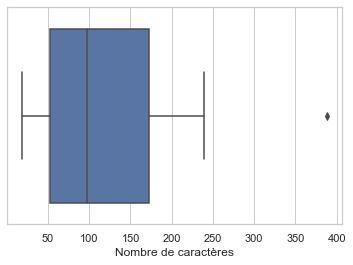

In [9]:
#deciles.reset_index(inplace=True)
#deciles.columns=["déciles","nb_caract"]
sns.set(style="whitegrid")
sns.boxplot(x=deciles["Nombre de caractères"])


In [ ]:
#start_time = time.time()

#contributions=pd.read_csv('contributions.csv',dtype={"authorZipCode":object})

#print("--- %s seconds ---" % (time.time() - start_time))

In [10]:
start_time = time.time()

def compte_group(df,nom,fichier=None,export=False):
    resultat=df.loc[df["Réponse"].str.contains(nom,case=False, regex=True)]
    ###On va mettre chaque thème dans une feuille différente
    ##D'abord on filtre les résultats par thèmes
    resultat["nb_occurr"]=resultat.loc[:,"Réponse"].str.count(pat=nom, flags=re.I)
    if export==True:
        resultat_1=resultat.loc[resultat["Thème"]=="DEMOCRATIE ET CITOYENNETE"]
        resultat_2=resultat.loc[resultat["Thème"]=="LA FISCALITE ET LES DEPENSES PUBLIQUES"]
        resultat_3=resultat.loc[resultat["Thème"]=="LA TRANSITION ECOLOGIQUE"]
        resultat_4=resultat.loc[resultat["Thème"]=="ORGANISATION DE L'ETAT ET DES SERVICES PUBLIQUES"] # je sais que c'est public mais changer ça est trop chiant à faire pzrce que faudra changer le nom des thèmes (ou y'a la faute aussi)
    
        writer = pd.ExcelWriter(fichier+'.xlsx', engine='xlsxwriter')
    
        resultat_1.to_excel(writer, sheet_name="DEMOCRATIE")
        resultat_2.to_excel(writer, sheet_name="FISCALITE")
        resultat_3.to_excel(writer, sheet_name="TRANSITION_ECOLOGIQUE")
        resultat_4.to_excel(writer, sheet_name="ORGANISATION_DE_LETAT") 
    
        writer.save()
    return(resultat)

print("--- %s seconds ---" % (time.time() - start_time))


--- 0.0 seconds ---


On va prendre un exemple pour essayer notre code: toutes les contributions du GDN qui contiennent les mots pandémie, épidémie sras, coronavirus

In [ ]:
start_time = time.time()
corona=compte_group(contributions,r"\bpand[e-é]mi[a-z]\b|\b[e-é]pid[e-é]mi[a-z]\b|\bsras\b|\bcoronavirus\b")


print("--- %s seconds ---" % (time.time() - start_time))

#DF series.apply est plus rapide que df.apply

#On ne  prend que les contributions de plus d'une phrase


In [ ]:
corona

In [ ]:
start_time = time.time()

aleo=corona["Réponse"].apply(nltk.sent_tokenize)
essai=pd.DataFrame(aleo.apply(pd.Series).stack()).reset_index()#la fonction series fait que le séparateur devient la virgule entre chaque éléments de la liste, le stack fait qu'on les empile, on a un multi index où chaque index de level 0= numéro de la contribution, level 1= numéro de la phrase dans la contribution

#On ajoute le nombre de phrases de chaque contributions
essai_gpby=essai.groupby(by="level_0",as_index=False)[0].count()

essai=essai.merge(essai_gpby,on="level_0")


essai.columns=["level_0","nb_sent","sent","nb_sent_total"]
contain=essai.loc[essai["sent"].str.contains(r"\bpand[e-é]mi[a-z]\b|\b[e-é]pid[e-é]mie\b|\bsras\b|\bcoronavirus\b",regex=True,case=False)]

# On met dans un dictionnaire l'index de chaque phrase contenant notre pattern
dico_lvl_contain=dict(zip(contain.index,zip(contain["nb_sent"],contain["nb_sent_total"])))

print("--- %s seconds ---" % (time.time() - start_time))

#DF series.apply est plus rapide que df.apply

#On ne  prend que les contributions de plus d'une phrase

Pour chaque phrase qui contient les mots qu'on veut, on prend celle d'avant et celle d'après. 
Si jamais la phrase qui contient les patterns est la première, python va renvoyer une erreur lorsqu'on va lui demander 
de prendre la phrase d'avant vu qu'il n'y a rien avant, viceversa si c'est après. 
Pour résoudre cela, on va dire à python d'exclure la première lorsqu'on lui demandera de prendre les phrases x-1 et la dernière phrase quand on lui demande de prendre les phrases x+1 (encore une fois si y'a rien après x on va avoir une erreur index out of bounds). 
On a selectionné dans une autre opérationles phrases qui contiennent le pattern, cette opération a pour but de prendre x-1 et x+1 pas x. 
Si la première phrase contient le pattern, python ne va prendre que celle qui la suit, et si dernière phrase contient le pattern, python ne va prendre que celle qui la précède, 
Si la première et la deuxième phrase contiennent le patern, python va prendre celle qui la suit (x+1), et la ligne suivante python va de nouveau prendre la première (x-1, qui contient le pattern),  et la troisème (x+1), la deuxième étant x sur cette ligne (x+1 la ligne précédente)

In [ ]:
start_time = time.time()

idx_avant=[[k-1,k,v] for (k,v) in dico_lvl_contain.items() if v[0]>0] #prend la phrase d'avant si la phrase  (celle qui matche le pattern) n'est pas la première de la contribution, donc d'index supérieur à 0
phrase_avant=essai.loc[[x[0] for x in idx_avant],]
phrase_avant["id_x"]=essai.loc[[x[1] for x in idx_avant],].index # On ajoute l'index des phrases qui contiennent la phrase du patern(celle d'après du coup si répond aux conditions du for)
phrase_avant.columns=["level_0","nb_sent_av", "sent_av","nb_sent_total","id_x"]

idx_apres=[[k+1,k,v] for (k,v) in dico_lvl_contain.items() if v[0]<(v[1]-1)] # # prend la phrase d'après si la phrase n'est pas la dernière de la contribution, donc d'index inférieure au nombre de phrases dans la contribution. on ajoute moins 1 parce que v[1] c'est la taille par ex 20 et v[0] c'est l'index (0:19) donc faut mettre v[1]-1 pour que ça corresponde

phrase_apres=essai.loc[[x[0] for x in idx_apres],]
phrase_apres["id_x"]=essai.loc[[x[1] for x in idx_apres],].index #On ajoute l'index des phrases du pattern (celle d'avant du coup si matche les conditions)
phrase_apres.columns=["level_0","nb_sent_ap", "sent_ap","nb_sent_total","id_x"]

contain=contain.rename_axis('id_x').reset_index() #On ajoute la colonne de l'id pour la jointure
essai_final=contain.merge(phrase_avant, on="id_x", how="outer").merge(phrase_apres,on="id_x",how="outer") #On fait une union des trois dataframes
print("--- %s seconds ---" % (time.time() - start_time))


In [ ]:
essai_final.loc[:,["sent_av","sent","sent_ap"]]

In [ ]:
essai_final['sent_av']=essai_final['sent_av'].astype(str).replace('nan','')
essai_final['sent_ap']=essai_final['sent_ap'].astype(str).replace('nan','')


In [ ]:
essai_final["phrase_av_ap"]=essai_final[['sent_av', 'sent','sent_ap']].apply(lambda x: ''.join(x), axis=1)


In [ ]:
essai_final.loc[:,"phrase_av_ap"][10]

In [ ]:
from spacy import displacy
import fr_core_news_sm
from spacy.lemmatizer import Lemmatizer
from spacy.lang.fr.stop_words import STOP_WORDS
nlp = fr_core_news_sm.load()
stop_list=["oui","non","faut","faudrait","une","qu","il","faut","y","faire","faudrait"," "]

nlp.Defaults.stop_words.update(stop_list)

# Iterates over the words in the stop words list and resets the "is_stop" flag.

for word in STOP_WORDS:
    lexeme = nlp.vocab[word]
    lexeme.is_stop = True
    
"""   
def lemmatizer(doc):
    # This takes in a doc of tokens from the NER and lemmatizes them. 
    # Pronouns (like "I" and "you" get lemmatized to '-PRON-', so I'm removing those.
    doc = [token.lemma_ for token in doc if token.lemma_ != '-PRON-']
    doc = u' '.join(doc)
    return nlp.make_doc(doc)
"""

def remove_stopwords(doc):
    # This will remove stopwords and punctuation.
    # Use token.text to return strings, which we'll need for Gensim.
    doc = [token.text for token in doc if token.is_stop != True and token.is_punct != True]
    return doc

# The add_pipe function appends our functions to the default pipeline.
#nlp.add_pipe(lemmatizer,name='lemmatizer',after='ner')
nlp.add_pipe(remove_stopwords, name="stopwords", last=True)


In [ ]:
#nlp1=fr_core_news_sm.load()

In [ ]:
doc_list = []
# Iterates through each article in the corpus.
for doc in tqdm(essai_final["phrase_av_ap"]):
    # Passes that article through the pipeline and adds to a new list.
    pr = nlp(doc)    
    doc_list.append(pr)

print(doc_list[10])

In [ ]:
dictionnaire = gensim.corpora.Dictionary(doc_list) # dictionnaire des tokens uniques

In [ ]:
dictionnaire.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

In [ ]:
corpus = [dictionnaire.doc2bow(doc) for doc in doc_list]

In [ ]:
doc_130 = corpus[130]
for i in range(len(doc_130)):
    print("Le mot {} (\"{}\") aparait {} fois.".format(doc_130[i][0], 
                                               dictionnaire[doc_130[i][0]], 
doc_130[i][1]))

In [ ]:
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [ ]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionnaire,
                                           num_topics=10, 
                                           random_state=2,
                                           update_every=1,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=False)

In [ ]:
pprint(lda_model.print_topics())

In [ ]:
#Evaluation modèle

print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=doc_list, dictionary=dictionnaire, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

In [ ]:
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
%matplotlib inline

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionnaire)
vis

In [ ]:
###Twitter####
# initialize api instance
auth = tw.OAuthHandler(consumer_key='',
                        consumer_secret=')

auth.set_access_token('',
                        '')
api = tw.API(auth, wait_on_rate_limit=True)

In [ ]:
swords=["pandemie","pandémie","epidémie","sras","coronavirus","épidémies","epidemies","pandémie","pandémies","covid","COVID", "Covid"]
OU=" OR "
search_words= OU.join(["#"+x for x in swords])
search_words+=" AND (@gouvernementFR OR @Elysee OR @EmmanuelMacron OR @Matignon OR @JeanCASTEX OR @MinSoliSante OR @olivierveran OR @AssembleeNat)"
search_words+=" -filter:links"
search_words+=" AND -filter:retweets"
search_words+=" AND -filter:replies"
search_date="2020-08-23"
print(search_words)

On prend le premier élément de la liste (on va considérer que si le tweet devait être labelisé par un hashtag, ce serait le premier mentionné), et on extrait les tags des dictionnaires avec leur clé

In [ ]:
tweets = tw.Cursor(api.search,
              q=search_words,
              lang="fr",
              since="2020-08-22", tweet_mode='extended').items(100)
def tweet_recup(tweets):
    tweet_list=[]
    for tweet in tweets:
        tweet_text=tweet.full_text
        tweed_id_str=tweet.id_str
        location=tweet.user.location
        username = tweet.user.screen_name
        acctdesc = tweet.user.description
        following = tweet.user.friends_count
        followers = tweet.user.followers_count
        totaltweets = tweet.user.statuses_count
        tweetcreatedts = tweet.created_at
        retweetcount = tweet.retweet_count
        hashtags = tweet.entities['hashtags']
        usercreatedts = tweet.user.created_at
        dico={"tweet_text":tweet_text,
                         "tweed_id_str":tweed_id_str,
                         "tweetcreatedts":tweetcreatedts,
                         "location":location,
                         "username":username,
                         "acctdesc":acctdesc,
                         "following":following,
                         "followers":followers,
                         "totaltweets":totaltweets,
                         "usercreatedts":usercreatedts,
                         "retweetcount": retweetcount,
                         "hashtags": hashtags}
        tweet_list.append(dico)
    tweets_df=pd.DataFrame(tweet_list,columns=list(dico.keys()))

    return tweets_df

df=tweet_recup(tweets)
#df.to_excel(r"C:\Users\Cheik\OneDrive - OCCURRENCE\Memoire-master\tweets_30_08.xlsx")

In [ ]:
df

In [ ]:
df["hashtags"].apply(lambda x: x[0]["text"]) # 

In [ ]:
import re
from nltk.tokenize import word_tokenize
from string import punctuation 
from nltk.corpus import stopwords 

class PreProcessTweets:
    def clean_tweet(self):
        '''
        Utility function to clean tweet text by removing links, special characters
        using simple regex statements.
        '''
        return ' '.join(re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", self).split())
    
    def stopwords(self):
        self._stopwords = nlp(self)
    """     
    def processTweets(self, list_of_tweets):
        processedTweets=[]
        for tweet in list_of_tweets:
            processedTweets.append((self._processTweet(tweet["text"]),tweet["label"]))
        return processedTweets
    """
    def _processTweet(self, tweet):
        tweet = tweet.lower() # convert text to lower-case
        tweet = re.sub(r'((www\.[^\s]+)|(https?://[^\s]+))', 'URL', tweet) # remove URLs
        tweet = re.sub(r'@[^\s]+', 'AT_USER', tweet) # remove usernames
        tweet = re.sub(r'#([^\s]+)', r'\1', tweet) # remove the # in #hashtag
        tweet = word_tokenize(tweet) # remove repeated characters (helloooooooo into hello)
        return [word for word in tweet if word not in self._stopwords]


On supprime les caractères spéciaux de nos tweets pour permettre au modèle d'analyse de sentiment qu'on va utiliser de reconnaitre le texte. Spécificité française: on va garder les voyelles avec des trémas, des circonflexes et des accents. Il ne s'agit pas de caractères spéciaux en français. 

On  fait également le choix de ne pas supprimer les hashtags mentionnés dans les tweets. Il semble qu'ils aient un sens et une valeur significatifs pour l'analyse de sentiments. 
(le 23/07): Certains tweets ont des tonalités contradictoires, peut-être est-ce les hashtags qui faussent les résultats

On va donc essayer de les supprimer pour voir s'il y a du mieux

In [ ]:
from textblob import TextBlob
from textblob_fr import PatternTagger, PatternAnalyzer

def test (df): ### le 23/07
    
    def clean_tweet(string):
        '''
        Utility function to clean tweet text by removing links, special characters
        using simple regex statements.
        '''
        pre=' '.join(re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z(àâäéèêëùûüïîôö) \t])|(\w+:\/\/\S+)", " ", string).split())
        
        return pre.lower()
        
    def sentiment_analyzer (text):
        c=TextBlob(text,pos_tagger=PatternTagger(),analyzer=PatternAnalyzer())
        return c.sentiment[0]
   
    def df_clean_sentiment(df1):
        df["clean_text"]=df["tweet_text"].apply(lambda x: clean_tweet(x))
        df["sentiment"]=df["clean_text"].apply(lambda x: sentiment_analyzer(x))
        
        df.loc[df["sentiment"]>0,"label"]="positif" # On met cette information dans une autre colonne et pas en remplaçant la valeur numérique pour pouvoir nuancer la positivité ou négativité après
        df.loc[df["sentiment"]==0,"label"]="neutre"
        df.loc[df["sentiment"]<0,"label"]="négatif"
        df["hashtags"]=df["hashtags"].apply(lambda x: x[0]["text"]) # On prend le premier élément de la liste (qui est le seul élement finalement), et on extrait les tags des dictionnaires avec leur cl

        #df["label_sentiment"]=df["label_sentiment"]
        return(df)
    
    return(df_clean_sentiment(df)) # On appelle notre fonction
#test(df).to_excel(r"C:\Users\Cheik\OneDrive - OCCURRENCE\Memoire-master\30_08_sentiments.xlsx")

In [ ]:
%matplotlib inline
sns.set(style="whitegrid")

In [ ]:
plt.pyplot.figure(figsize=(8,10))
ax=sns.countplot(y="hashtags",data=df).set_title("Nombre de tweets par hashtags")

In [ ]:
### Pourcentage de tweets par sentiments
pcent_pos=(len(df.loc[df["label"]=="positif"])/len(df))*100

pcent_neg=(len(df.loc[df["label"]=="négatif"])/len(df))*100

pcent_neut=(len(df.loc[df["label"]=="neutre"])/len(df))*100

dico_sentiment={"positif": (len(df.loc[df["label"]=="positif"])/len(df))*100,
                "negatif": (len(df.loc[df["label"]=="négatif"])/len(df))*100,
                "neutre":  (len(df.loc[df["label"]=="neutre"])/len(df))*100}

for k,v in dico_sentiment.items():
    print('Le sentiment associé aux tweets est à {} % {}'.format(v,k))

In [ ]:
### Hashtags par polarité moyenne
sent_hashtag=df.groupby(by="hashtags",as_index=False).mean().loc[:,["hashtags","sentiment"]]

plt.pyplot.figure(figsize=(8,10))
sns.barplot(y=sent_hashtag["hashtags"],x=sent_hashtag["sentiment"], orient="h").set_title("Hashtags par polarité moyenne")


In [ ]:
# Stopwords et punct removal perso, mais on va plutôt utiliser celui de Spacy
'''
def stop_words(liste=False):
    stopwords=pd.read_csv("stopwords.csv",sep=';')
    nvx_stpwds=pd.DataFrame(liste,dtype=str)
    stopwords=pd.concat([stopwords["a"],nvx_stpwds[0]],axis=0,ignore_index=True)
    stopwords=pd.concat([stopwords,stopwords.str.upper(),stopwords.str.capitalize()],axis=0, ignore_index=True)
    
    return(stopwords.tolist())
stopwords=stop_words(['oui','non','faut','faudrait','une','qu','il'])


essai_final["text_processed"] = essai_final["phrase_av_ap"].map(lambda x: re.sub('[,\.!?:]', ' ', x))
essai_final["text_processed"]=essai_final["text_processed"].map(lambda x:' '.join([word for word in x.split() if word not in (stopwords)]))#On enlève les stopwords

'''

In [ ]:
"""from gensim import corpora, models
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]
for doc in corpus_tfidf:
    pprint(doc)
    break
    
###LDA_multicore
lda_model = gensim.models.LdaMulticore(corpus, num_topics=5, id2word=dictionnaire, passes=2, workers=4)

for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))
    
#évaluation modèle
liste_topic=[]
for index, score in sorted(lda_model[corpus[50]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 1)))
    liste_topic.append((score, lda_model.print_topic(index, 1))
    """

In [ ]:
###Pour les grosses requêtes
def scraptweets(search_words, date_since, numTweets, numRuns):
    
    # Define a for-loop to generate tweets at regular intervals
    # We cannot make large API call in one go. Hence, let's try T times
    
    # Define a pandas dataframe to store the date:
    db_tweets = pd.DataFrame(columns = ['username', 'tweed_id_str','acctdesc', 'location', 'following',
                                        'followers', 'totaltweets', 'usercreatedts', 'tweetcreatedts',
                                        'retweetcount', 'tweet_text', 'hashtags']
                                )
    program_start = time.time()
    
    for i in range(0, numRuns):
        # We will time how long it takes to scrape tweets for each run:
        start_run = time.time()
        
        # Collect tweets using the Cursor object
        # .Cursor() returns an object that you can iterate or loop over to access the data collected.
        # Each item in the iterator has various attributes that you can access to get information about each tweet
        tweets = tw.Cursor(api.search, q=search_words, lang="fr", since=search_date, tweet_mode='extended').items(numTweets)
        ##tweets = tw.Cursor(api.search, q=search_words, lang="fr", since=search_date, tweet_mode='extended').items(numTweets)
# Store these tweets into a python list
        tweet_list = [tweet for tweet in tweets]
# Obtain the following info (methods to call them out):
        # user.screen_name - twitter handle
        # user.description - description of account
        # user.location - where is he tweeting from
        # user.friends_count - no. of other users that user is following (following)
        # user.followers_count - no. of other users who are following this user (followers)
        # user.statuses_count - total tweets by user
        # user.created_at - when the user account was created
        # created_at - when the tweet was created
        # retweet_count - no. of retweets
        # (deprecated) user.favourites_count - probably total no. of tweets that is favourited by user
        # retweeted_status.full_text - full text of the tweet
        # tweet.entities['hashtags'] - hashtags in the tweet
# Begin scraping the tweets individually:
        noTweets = 0
        for tweet in tweet_list:
# Pull the values
            username = tweet.user.screen_name
            tweed_id_str=tweet.id_str
            acctdesc = tweet.user.description
            location = tweet.user.location
            following = tweet.user.friends_count
            followers = tweet.user.followers_count
            totaltweets = tweet.user.statuses_count
            usercreatedts = tweet.user.created_at
            tweetcreatedts = tweet.created_at
            retweetcount = tweet.retweet_count
            hashtags = tweet.entities['hashtags']
            try:
                tweet_text = tweet.retweeted_status.full_text
            except AttributeError:  # Not a Retweet
                tweet_text = tweet.full_text
# Add the 11 variables to the empty list - ith_tweet:
            ith_tweet = [username, tweed_id_str, acctdesc, location, following, followers, totaltweets,
                         usercreatedts, tweetcreatedts, retweetcount, tweet_text, hashtags]
# Append to dataframe - db_tweets
            db_tweets.loc[len(db_tweets)] = ith_tweet
# increase counter - noTweets  
            noTweets += numTweets
        # Run ended:
            end_run = time.time()
            duration_run = round((end_run-start_run)/60, 2)
        
            print('no. of tweets scraped for run {} is {}'.format(i + 1, noTweets))
            print('time take for {} run to complete is {} mins'.format(i+1, duration_run))
        
            time.sleep(900) #15 minute sleep time
        
        
        """
  from datetime import datetime
    
    # Obtain timestamp in a readable format
    export_timestamp = datetime.today().strftime('%Y%m%d_%H%M%S')
# Define working path and filename
    path = os.getcwd()
    filename = path+"tweets"+export_timestamp+".xlsx"
# Store dataframe in csv with creation date timestamp
    db_tweets.excel(filename, index = False)
    
    program_end = time.time()
    print('Scraping has completed!')
    print('Total time taken to scrap is {} minutes.'.format(round(program_end - program_start)/60, 2))
"""
    db_tweets["hashtags"]=db_tweets["hashtags"].apply(lambda x: x[0]["text"]) # On prend le premier élément de la liste (qui est le seul élement finalement), et on extrait les tags des dictionnaires avec leur cl
    return(db_tweets)

 

In [ ]:
db_tweets=scraptweets(search_words=search_words, date_since="2020-08-22", numTweets=15, numRuns=14)

In [ ]:
"""###Grosse fonction pour occurrence à retravailler

from textblob import TextBlob
from textblob_fr import PatternTagger, PatternAnalyzer
class ProcessTweets:
    def clean_tweet(self):
        '''
        Fonction de nettoyage de tweets, supprimant les liens, les caractères spéciaux en utilisant des regex et supprimant les stopwords, 
        la ponctuation, et tokenizant  en utilisant nlp() de spacy (auquel on ajouté la suppression des stopwords)
        '''
        pre=' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z(àâäéèêëùûüïîôö) \t])|(\w+:\/\/\S+)", " ", self).split())
        return pre.lower
    def df_clean(df):
        text=pd.DataFrame(df["tweet_text"].apply(lambda x: PreProcessTweets.clean_tweet(x)))
        return(text)
    
    def get_tweet_sentiment(tweet):
        '''
        Utility function to classify sentiment of passed tweet
        using textblob's sentiment method
        '''
        # create TextBlob object of passed tweet text
       # analysis=text.apply(lambda tweet: TextBlob(tweet).sentiment)
        polarité=TextBlob(tweet,pos_tagger=PatternTagger(),analyzer=PatternAnalyzer())
            
        if polarité.sentiment.polarity > 0:
            return 'positive'
        elif polarité.sentiment.polarity == 0:
            return 'neutral'
        else:
            return 'negative'
        """

Constat assez mitigé pour notre modèle d'analyse de sentiments. Les tweets désignéss par Textblob comme étant négatifs, semblent corrects (autrement dit je les aurais aussi catégorisés comme négatifs). Pour les tweets positifs en revanche, je ne suis pas tout à fait convaincu. A vrai dire j'ai beaucoup de mal à les faire rentrer dans une catégorie par conséquent j'en aurais mis une bonne partie dans les neutres. Toutefois, il n'est pas scandaleux de voir qu'ils ont une polarité supérieure à 0 (peuvent être interprétés comme ayant un sentiment positif) d'autant que la polarité des tweets positifs les plus "discutables" est très proche de 0.
Je pense donc que plutôt que regarder les labels (positfs, négatifs ou neutres) il fauat regarder la polarité. Du coup ce que je vais sûrement faire c'est ajouter des catégories intermédiaires par exemple (peu positif, très positif assez positif) etc... Pour nuancer les sentiment et analyser plus précisément. 

Vérifier aussi si dans mon expression régulière les caractères que je décide de garder ne biaisent pas peu le sentiment idem pour les hastags que j'ai décidé de garder
En outre, il serait intéressant de voir si je fais les mêmes constats sur un corpus de tweets plus important en utilisant la grosse fonction plus haut. A voir....
Désormais je vais faire quelques statistiques